<a href="https://colab.research.google.com/github/rafaelMartins1922/kaggle-fraud-detection-challenge/blob/main/iee_cis_fraud_detection_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, Binarizer, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, plot_roc_curve
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
cols = ["TransactionID", "TransactionAmt","TransactionDT", "ProductCD","card4", "card6", "isFraud"]

train_transaction = pd.read_csv("/content/drive/MyDrive/teste/train_transaction.csv", usecols=cols)
test_transaction = pd.read_csv("/content/drive/MyDrive/teste/test_transaction.csv", usecols= [col for col in cols if col != 'isFraud'])

train_identity = pd.read_csv("/content/drive/MyDrive/teste/train_identity.csv")
test_identity = pd.read_csv("/content/drive/MyDrive/teste/test_identity.csv")

train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction,test_identity, on = 'TransactionID', how = 'left')

In [ ]:
print('train:',train.shape)
print('test:', test.shape)

train: (590540, 47)
test: (506691, 46)


In [6]:
# Data Transformation
## dropping nulls
train.dropna(thresh=train.shape[0]*0.5,how='all',axis=1, inplace=True)
test = test[[col for col in list(train.columns) if col != 'isFraud']]

## filling nulls
train = train.fillna(train.mode().iloc[0])

## normalization, standardization
continuous = train.select_dtypes(include=[np.number]).columns # all continuous columns
categorical = train.select_dtypes(exclude=[np.number]).columns 
train[continuous] = (train[continuous]-train[continuous].mean())/train[continuous].std() 
train[continuous] = (train[continuous]-train[continuous].min())/(train[continuous].max()-train[continuous].min())

In [11]:
def evaluate_supervised_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    ra_score = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print('Acurácia: ', accuracy)
    print('Precisão: ', precision)
    print('Recall: ', recall)
    print('ROC AUC Score: ', ra_score)
    print('F1: ', f1)
    plot_roc_curve(model, X_test, y_test, name=f'ROC Curve - {model_name}')
    
    return {'Acurácia':accuracy, 'Precisão':precision, 'Recall': recall, 'ROC AUC Score':ra_score, 'F1':f1}


Decision Tree Classifier - No resampling
Acurácia:  0.9612642666034477
Precisão:  0.4477777777777778
Recall:  0.49086479902557856
ROC AUC Score:  0.7345335635172453
F1:  0.46833236490412544
   Acurácia  Precisão    Recall  ROC AUC Score        F1
0  0.961264  0.447778  0.490865       0.734534  0.468332

Decision Tree Classifier - Undersampling


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.7195741592063876
Precisão:  0.7019761029411765
Recall:  0.7495093228655545
ROC AUC Score:  0.7199813917430398
F1:  0.7249644043663976

Decision Tree Classifier - Oversampling


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.9879886466828397
Precisão:  0.9764815021603003
Recall:  1.0
ROC AUC Score:  0.9880196026953706
F1:  0.9881008257279444
   Acurácia  Precisão    Recall  ROC AUC Score        F1
0  0.961264  0.447778  0.490865       0.734534  0.468332
1  0.719574  0.701976  0.749509       0.719981  0.724964
2  0.987989  0.976482  1.000000       0.988020  0.988101


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


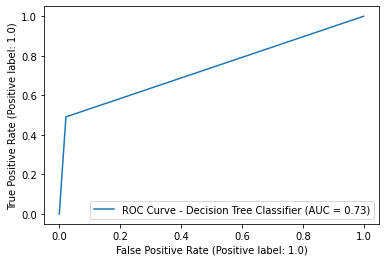

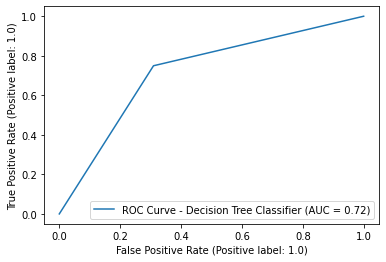

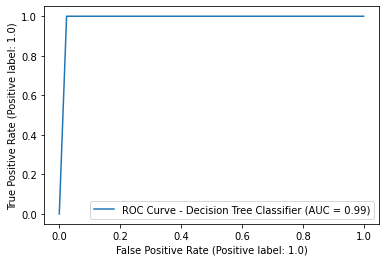

In [12]:
# Supervised learning - Decision Tree Classifier
features = ["TransactionID", "TransactionAmt","TransactionDT", "ProductCD","card4", "card6"]
target = 'isFraud'
#Data split - No sampling
X = train[features]
y = train[target]

decision_tree_results = pd.DataFrame()

print('\nDecision Tree Classifier - No resampling')
dtc = DecisionTreeClassifier()
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

new_results = evaluate_supervised_model(dtc, X_train, X_test, y_train, y_test, 'Decision Tree Classifier')
decision_tree_results = decision_tree_results.append(new_results, ignore_index=True)

print(decision_tree_results)

print('\nDecision Tree Classifier - Undersampling')
dtc = DecisionTreeClassifier()
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X,y)
X_rus = pd.get_dummies(X_rus)
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.20)
new_results = evaluate_supervised_model(dtc, X_train_rus, X_test_rus, y_train_rus, y_test_rus, 'Decision Tree Classifier')
decision_tree_results = decision_tree_results.append(new_results, ignore_index=True)

print('\nDecision Tree Classifier - Oversampling')
dtc = DecisionTreeClassifier()

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X,y)
X_ros = pd.get_dummies(X_ros)

X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size=0.20)

new_results = evaluate_supervised_model(dtc, X_train_ros, X_test_ros, y_train_ros, y_test_ros, 'Decision Tree Classifier')
decision_tree_results = decision_tree_results.append(new_results, ignore_index=True)

print(decision_tree_results)


Random Forest Classifier - No resampling
Acurácia:  0.9721949402242016
Precisão:  0.6632970451010887
Recall:  0.41367604267701263
ROC AUC Score:  0.7030392425625378
F1:  0.509557945041816


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


   Acurácia  Precisão    Recall  ROC AUC Score        F1
0  0.972195  0.663297  0.413676       0.703039  0.509558

Random Forest Classifier - Undersampling
Acurácia:  0.7443745463343818
Precisão:  0.7308802308802309
Recall:  0.7535333498636251
ROC AUC Score:  0.7445909130607992
F1:  0.7420339396899035


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)



Random Forest Classifier - Oversampling
Acurácia:  0.9907655592649297
Precisão:  0.9818346565412496
Recall:  1.0
ROC AUC Score:  0.9907817755044843
F1:  0.9908340772027607


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


   Acurácia  Precisão    Recall  ROC AUC Score        F1
0  0.972195  0.663297  0.413676       0.703039  0.509558
1  0.744375  0.730880  0.753533       0.744591  0.742034
2  0.990766  0.981835  1.000000       0.990782  0.990834


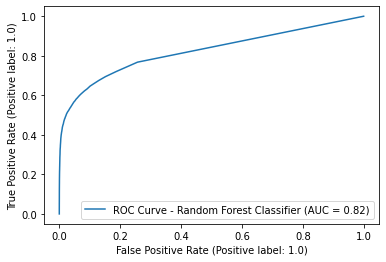

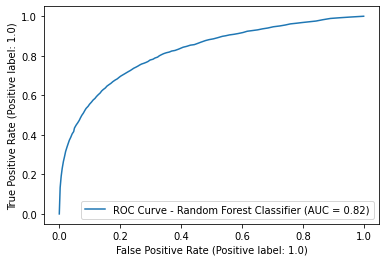

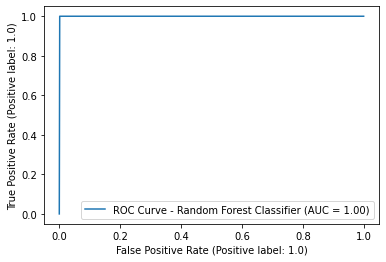

In [13]:
# Supervised learning - Random Forest Classifier
random_forest_results = pd.DataFrame()

print('\nRandom Forest Classifier - No resampling')

rfc = RandomForestClassifier()
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

new_results = evaluate_supervised_model(rfc, X_train, X_test, y_train, y_test, 'Random Forest Classifier')
random_forest_results = random_forest_results.append(new_results, ignore_index=True)

print(random_forest_results)

print('\nRandom Forest Classifier - Undersampling')
rfc = RandomForestClassifier()

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X,y)
X_rus = pd.get_dummies(X_rus)
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.20)

new_results = evaluate_supervised_model(rfc, X_train_rus, X_test_rus, y_train_rus, y_test_rus, 'Random Forest Classifier')
random_forest_results = random_forest_results.append(new_results, ignore_index=True)

print('\nRandom Forest Classifier - Oversampling')
rfc = RandomForestClassifier()

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X,y)
X_ros = pd.get_dummies(X_ros)
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size=0.20)

new_results = evaluate_supervised_model(rfc, X_train_ros, X_test_ros, y_train_ros, y_test_ros, 'Random Forest Classifier')
random_forest_results = random_forest_results.append(new_results, ignore_index=True)

print(random_forest_results)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Silhouette Score(n=2): <function silhouette_score at 0x7f32dcc9aca0>
Calinski-Harabasz score(n=2): 49499.797361830286
   Sillhuette Score  Calinski-Harabasz Score
0          0.385958             49499.797362 {'Sillhuette Score': 0.3859579143716637, 'Calinski-Harabasz Score': 49499.797361830286}


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Silhouette Score(n=2): <function silhouette_score at 0x7f32dcc9aca0>
Calinski-Harabasz score(n=2): 3594.155602825945
   Sillhuette Score  Calinski-Harabasz Score
0          0.385958             49499.797362
1          0.344296              3594.155603


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Silhouette Score(n=2): <function silhouette_score at 0x7f32dcc9aca0>
Calinski-Harabasz score(n=2): 99829.67870810955
   Sillhuette Score  Calinski-Harabasz Score
0          0.385958             49499.797362
1          0.344296              3594.155603
2          0.346893             99829.678708


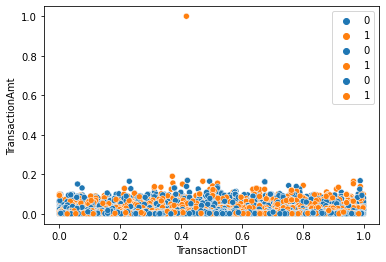

In [14]:
KMean= KMeans(n_clusters=2)

kmeans_results = pd.DataFrame()
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

KMean.fit(X_train)
label=KMean.predict(X_test)

s_score = silhouette_score(X_test, label)
print(f'Silhouette Score(n=2): {silhouette_score}')

ch_score = calinski_harabasz_score(X_test, label)
print(f'Calinski-Harabasz score(n=2): {ch_score}')

new_results = {'Sillhuette Score': s_score, 'Calinski-Harabasz Score': ch_score}
kmeans_results = kmeans_results.append(new_results, ignore_index=True)

print(kmeans_results, new_results)

KMean= KMeans(n_clusters=2)

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X,y)
X_rus = pd.get_dummies(X_rus)
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.20)

KMean.fit(X_train_rus)
label=KMean.predict(X_test_rus)

s_score = silhouette_score(X_test_rus, label)
print(f'Silhouette Score(n=2): {silhouette_score}')

ch_score = calinski_harabasz_score(X_test_rus, label)
print(f'Calinski-Harabasz score(n=2): {ch_score}')

new_results = {'Sillhuette Score': s_score, 'Calinski-Harabasz Score': ch_score}
kmeans_results = kmeans_results.append(new_results, ignore_index=True)
print(kmeans_results)

KMean= KMeans(n_clusters=2)
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X,y)
X_ros = pd.get_dummies(X_ros)
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size=0.20)

KMean.fit(X_train_ros)
label=KMean.predict(X_test_ros)

s_score = silhouette_score(X_test_ros, label)
print(f'Silhouette Score(n=2): {silhouette_score}')

ch_score = calinski_harabasz_score(X_test_ros, label)
print(f'Calinski-Harabasz score(n=2): {ch_score}')

new_results = {'Sillhuette Score': s_score, 'Calinski-Harabasz Score': ch_score}
kmeans_results = kmeans_results.append(new_results, ignore_index=True)
print(kmeans_results)

In [15]:
print(decision_tree_results)
print(random_forest_results)
print(kmeans_results)

   Acurácia  Precisão    Recall  ROC AUC Score        F1
0  0.961264  0.447778  0.490865       0.734534  0.468332
1  0.719574  0.701976  0.749509       0.719981  0.724964
2  0.987989  0.976482  1.000000       0.988020  0.988101
   Acurácia  Precisão    Recall  ROC AUC Score        F1
0  0.972195  0.663297  0.413676       0.703039  0.509558
1  0.744375  0.730880  0.753533       0.744591  0.742034
2  0.990766  0.981835  1.000000       0.990782  0.990834
   Sillhuette Score  Calinski-Harabasz Score
0          0.385958             49499.797362
1          0.344296              3594.155603
2          0.346893             99829.678708


['Acurácia', 'Precisão', 'Recall', 'ROC AUC Score', 'F1']


<Figure size 720x288 with 0 Axes>

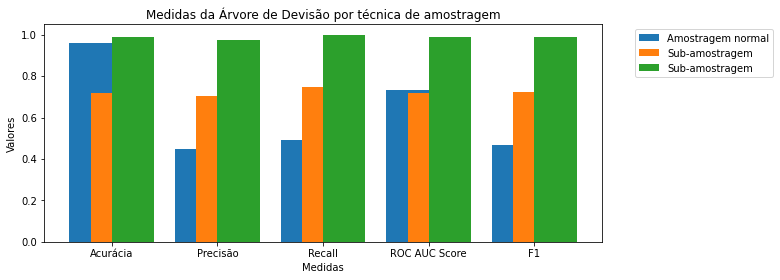

In [16]:
plot_X = list(decision_tree_results.columns)
print(plot_X)

X_axis = np.arange(len(plot_X))
plt.figure().set_figwidth(10)


plt.figure().set_figwidth(10)
plt.bar(X_axis - 0.2, decision_tree_results.iloc[0], 0.4, label= 'Amostragem normal')
plt.bar(X_axis, decision_tree_results.iloc[1] , 0.4, label= 'Sub-amostragem')
plt.bar(X_axis+0.2, decision_tree_results.iloc[2] , 0.4, label= 'Sub-amostragem')

plt.xticks(X_axis, plot_X)
plt.xlabel('Medidas')
plt.ylabel(f'Valores')
plt.title(f'Medidas da Árvore de Devisão por técnica de amostragem')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

['Acurácia', 'Precisão', 'Recall', 'ROC AUC Score', 'F1']


<Figure size 720x288 with 0 Axes>

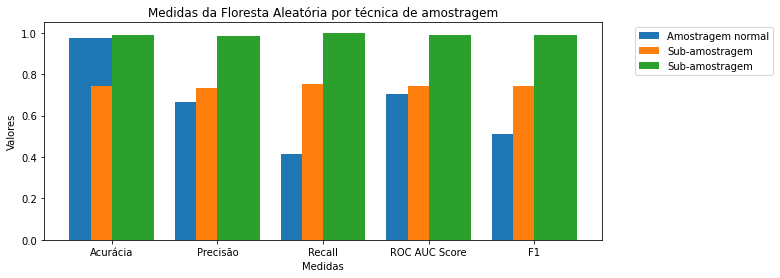

In [17]:
plot_X = list(random_forest_results.columns)
print(plot_X)

X_axis = np.arange(len(plot_X))
plt.figure().set_figwidth(10)


plt.figure().set_figwidth(10)
plt.bar(X_axis - 0.2, random_forest_results.iloc[0], 0.4, label= 'Amostragem normal')
plt.bar(X_axis, random_forest_results.iloc[1] , 0.4, label= 'Sub-amostragem')
plt.bar(X_axis+0.2, random_forest_results.iloc[2] , 0.4, label= 'Sub-amostragem')

plt.xticks(X_axis, plot_X)
plt.xlabel('Medidas')
plt.ylabel(f'Valores')
plt.title(f'Medidas da Floresta Aleatória por técnica de amostragem')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

[0.3859579143716637, 0.3442960044399569, 0.34689321041595916]


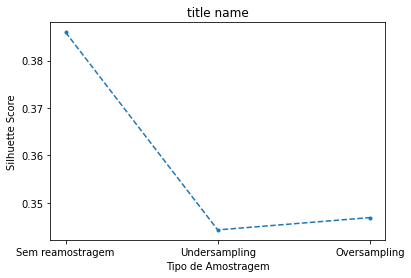

[49499.797361830286, 3594.155602825945, 99829.67870810955]


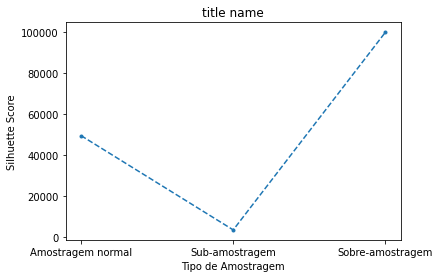

In [18]:
x_axis = ['Sem reamostragem' ,'Undersampling', 'Oversampling']
y_axis = list(kmeans_results['Sillhuette Score'])
print(y_axis)

plt.plot(x_axis, y_axis, marker='.', linestyle='dashed')
plt.title('title name')
plt.xlabel('Tipo de Amostragem')
plt.ylabel('Silhuette Score')
plt.show()

x_axis = ['Amostragem normal' ,'Sub-amostragem', 'Sobre-amostragem']
y_axis = list(kmeans_results['Calinski-Harabasz Score'])
print(y_axis)

plt.plot(x_axis, y_axis, marker='.', linestyle='dashed')
plt.title('title name')
plt.xlabel('Tipo de Amostragem')
plt.ylabel('Silhuette Score')
plt.show()